In [2]:
import sys
src_dir = '/Users/palmerio/Science_projects/GRB_population_model/src/'
sys.path.insert(0, src_dir)
verbose = True
run_mode = 'debug'
import prototype_GRB_population as pt
from GRB_population import GRBPopulation
import physics as ph
import numpy as np
import io_grb_pop as io
import miscelaneous as msc
from cosmology import init_cosmology
from ECLAIRs import init_ECLAIRs
import observational_constraints as obs

In [3]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('presentation')


In [4]:
paths_to_dir, paths_to_files = io.generate_paths()

14:18:37.729 [DEBUG] Root directory is /Users/palmerio/Science_projects/GRB_population_model
14:18:37.730 [DEBUG] Directory paths :
    'root'    : /Users/palmerio/Science_projects/GRB_population_model
    'obs'     : /Users/palmerio/Science_projects/GRB_population_model/observational_constraints
    'init'    : /Users/palmerio/Science_projects/GRB_population_model/init
    'output'  : /Users/palmerio/Science_projects/GRB_population_model/model_outputs
    'data'    : /Users/palmerio/Science_projects/GRB_population_model/data
    'cosmo'   : /Users/palmerio/Science_projects/GRB_population_model/data/cosmology
    'ECLAIRs' : /Users/palmerio/Science_projects/GRB_population_model/data/ECLAIRs
14:18:37.731 [DEBUG] File paths :
    'config'  : /Users/palmerio/Science_projects/GRB_population_model/init/config.yml
    'param'   : /Users/palmerio/Science_projects/GRB_population_model/init/parameters.yml
    'instrum' : /Users/palmerio/Science_projects/GRB_population_model/init/instruments.yml

In [17]:
config, params, instruments, samples = io.read_init_files(paths_to_files)
config['Nb_GRBs'] = '2.5e5'
config['samples'] = ['Stern', 'EpGBM', 'eBAT6']
config['output_dir'] = 'debugger'
params['spectral_shape']['model'] = 'GBM_Band_old'
paths_to_dir['output'] = paths_to_dir['output']/config['output_dir']
config
params

14:20:11.862 [DEBUG] Input configuration:
Nb_GRBs: 1e6
likelihood:
    epsilon: 0.001
output_dir: ECLAIRs_best_A
samples:
- Stern
- EpGBM
- Swift
- ECLAIRs
save_all_GRBs: false

14:20:11.865 [DEBUG] Input parameters:
Cvar_distribution:
    correl_slope: 0.413
    mu: 0.04
    sigma: 0.22
luminosity_function:
    k_evol: 1.0
    logLbreak: 52.56
    logLmax: 53.0
    logLmin: 49.6989700043
    model: ES
    slope: 1.41
peak_energy_distribution:
    Ep0: 690
    alpha_amati: 0.3
    model: LN
    sigmaEp: 0.45
redshift_distribution:
    a: 0.94
    b: -0.52
    model: BExp
    zeta: null
    zm: 2.18
    zmax: 20
spectral_shape:
    alpha: 0.6
    beta: 2.5
    model: GBM_Band
t90obs_distribution:
    mu: 1.45
    sigma: 0.47



{'luminosity_function': {'model': 'ES',
  'logLmin': 49.6989700043,
  'logLmax': 53.0,
  'logLbreak': 52.56,
  'slope': 1.41,
  'k_evol': 1.0},
 'redshift_distribution': {'model': 'BExp',
  'zmax': 20,
  'zm': 2.18,
  'a': 0.94,
  'b': -0.52,
  'zeta': None},
 'spectral_shape': {'model': 'GBM_Band_old', 'alpha': 0.6, 'beta': 2.5},
 'peak_energy_distribution': {'model': 'LN',
  'Ep0': 690,
  'sigmaEp': 0.45,
  'alpha_amati': 0.3},
 't90obs_distribution': {'mu': 1.45, 'sigma': 0.47},
 'Cvar_distribution': {'mu': 0.04, 'sigma': 0.22, 'correl_slope': 0.413}}

In [6]:
print(paths_to_dir['output'])

/Users/palmerio/Science_projects/GRB_population_model/model_outputs/debugger


In [7]:
cosmo = init_cosmology(paths_to_dir['cosmo'])
ECLAIRs_prop = init_ECLAIRs(ECLAIRs_dir=paths_to_dir['ECLAIRs'],
                            ECLAIRs_config=instruments['ECLAIRs'])
samples['ECLAIRs']['pflx_min'] = ECLAIRs_prop['bkg_total']

Nb_GRBs = int(float(config['Nb_GRBs']))

incl_samples = msc.included_samples(config['samples'], samples)
incl_instruments = msc.included_instruments(incl_samples, instruments)

14:18:39.413 [DEBUG] ==============================================
14:18:39.414 [DEBUG] ===           ECLAIRs instrument           ===
14:18:39.414 [DEBUG] ==============================================
14:18:39.415 [DEBUG] ECLAIRs energy channel: 4.0 to 150.0 keV
14:18:39.416 [DEBUG] ECLAIRs detection level: 6.5 sigmas
14:18:39.444 [DEBUG] Effective area: from 1.013650e+02 cm2 at 4.00 keV
14:18:39.446 [DEBUG] Effective area: to   1.811580e+02 cm2 at 250.00 keV
14:18:39.447 [DEBUG] Background: from 2.819620e+02 cts/s/keV at 4.00 keV
14:18:39.449 [DEBUG] Background: to   8.730200e-02 cts/s/keV at 250.00 keV
14:18:39.450 [DEBUG] ECLAIRs background: 3.098396e+03 cts/s from 4.00 keV to 150.00 keV
14:18:39.452 [DEBUG] ==============================================
14:18:39.453 [INFO] Including samples: ['Stern', 'EpGBM', 'eBAT6']
14:18:39.456 [DEBUG] Including samples:
EpGBM:
    instrument: BATSE
    pflx_min: 0.9
Stern:
    instrument: BATSE
    pflx_min: 0.066825
eBAT6:
    instrument: 

14:18:39.891 [INFO] Debug mode activated; plotting z pdf
14:18:39.991 [INFO] Debug mode activated; plotting L pdf
14:18:40.058 [INFO] Debug mode activated; plotting Ep pdf
14:18:40.121 [INFO] Debug mode activated; plotting t90obs pdf
14:18:40.187 [INFO] Debug mode activated; plotting Cvar pdf
14:18:40.343 [INFO] Debug mode activated; plotting spectral params pdf
===                         SUMMARY                                ===
 prop 	| median 	| stdev 	| min    	| max
---------------------------------------------------------------------- 
 z	| 2.35600e+00 	| 1.38644e+00 	| 4.30000e-02 	| 1.83730e+01 
 L	| 7.51695e+50 	| 2.30893e+52 	| 5.75804e+49 	| 1.52348e+54 
 Ep	| 6.89231e+02 	| 1.61816e+03 	| 7.35767e+00 	| 7.92361e+04 
 t90obs	| 2.82177e+01 	| 7.72596e+01 	| 1.58301e-01 	| 4.97177e+03 
 Cvar	| 2.75900e-01 	| 2.22085e-01 	| 1.13724e-02 	| 1.00000e+00 
 alpha	| 6.50022e-01 	| 3.29221e-01 	| -7.05642e-01 	| 1.72638e+00 
 beta	| 2.49859e+00 	| 4.09489e-01 	| 2.00168e+00 	| 4.048

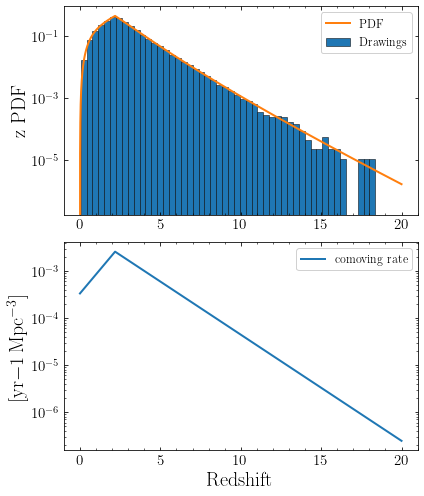

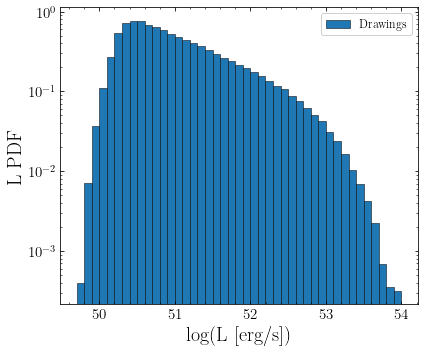

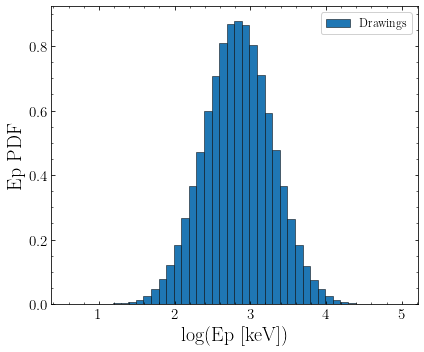

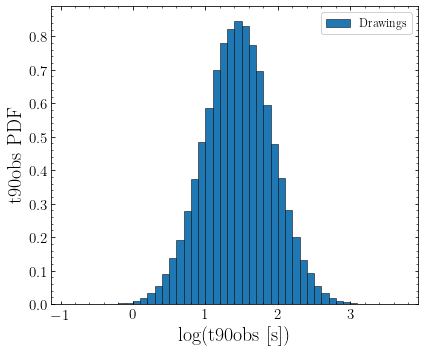

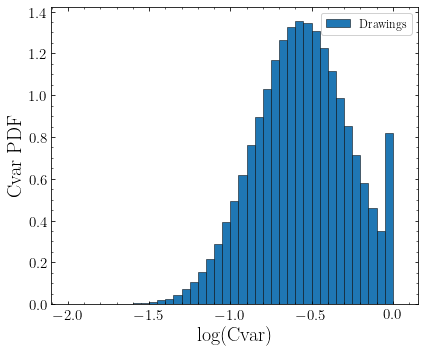

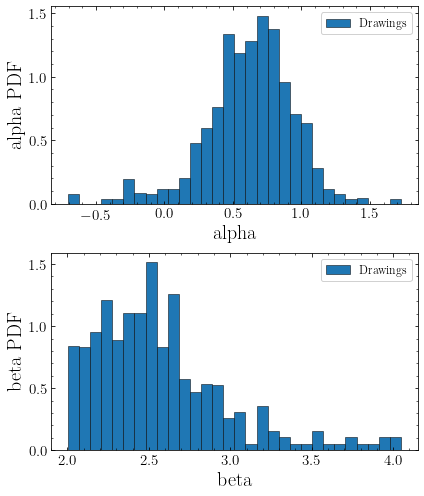

In [8]:
# np.random.seed(1)
GRB_population = GRBPopulation(Nb_GRBs, output_dir=paths_to_dir['output'])
GRB_prop = GRB_population.draw_GRB_properties(cosmo=cosmo, params=params, run_mode='debug')

ph.calc_peak_photon_flux(GRB_prop, incl_instruments, ECLAIRs_prop)
# ph.calc_peak_energy_flux(GRB_prop, incl_instruments, ECLAIRs_prop)
# ph.calc_photon_fluence(GRB_prop, incl_instruments)
# ph.calc_energy_fluence(GRB_prop, incl_instruments)
ph.calc_det_prob(GRB_prop, incl_samples, **ECLAIRs_prop)

In [9]:
df = pd.DataFrame(GRB_prop)
df

,Nb_GRBs,z,L,Ep,t90obs,Cvar,alpha,beta,ktild,D_L,Epobs,Eiso,t90,pht_pflx_BATSE,pht_pflx_BAT,pdet_Stern,pdet_EpGBM,pdet_eBAT6
0,250000,2.239,4.646207e+52,46.587320,853.852784,0.028640,1.157480,2.44093,0.525046,18084.168664,14.383242,3.507845e+53,263.616173,1.370980,7.993202,1.0,1.0,1.0
1,250000,3.406,6.584429e+51,594.407080,23.340281,0.734151,0.640296,2.06821,0.242129,30130.470782,134.908552,2.560739e+52,5.297386,0.033434,0.060185,0.0,0.0,0.0
2,250000,3.763,1.606761e+52,1043.714441,3.819666,0.979465,0.241049,2.35362,1.412530,33961.332536,219.129633,1.262075e+52,0.801945,0.179458,0.216312,1.0,0.0,0.0
3,250000,1.672,1.037583e+52,461.199770,100.721456,0.248510,0.631182,2.90923,1.423128,12603.191372,172.604704,9.719690e+52,37.695156,1.561200,2.534145,1.0,1.0,0.0
4,250000,0.930,2.030330e+50,365.918936,1.891026,0.759264,-0.640853,3.39893,7.545961,6060.348415,189.595303,1.510426e+50,0.979806,0.147672,0.141180,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,250000,3.607,3.884980e+50,269.414023,4.500942,0.406833,0.842272,2.69554,0.981516,32280.432896,58.479276,1.544152e+50,0.976979,0.008223,0.027025,0.0,0.0,0.0
249996,250000,1.432,2.715443e+51,738.762149,15.799983,0.577202,0.705592,2.54189,1.050105,10391.248459,303.767331,1.018267e+52,6.496704,0.347099,0.471750,1.0,0.0,0.0
249997,250000,3.884,5.512425e+50,1420.918627,24.626657,0.204639,0.928527,3.88595,1.082942,35272.081782,290.933380,5.688029e+50,5.042313,0.008875,0.014082,0.0,0.0,0.0
249998,250000,3.331,6.665513e+52,360.979151,20.491131,0.286802,0.516401,2.63554,1.429738,29333.058446,83.347761,9.044673e+52,4.731270,1.913665,4.537914,1.0,1.0,1.0


19:52:27.160 [INFO] Global GRB rate: [117.26818886 111.3533665  118.68206271  96.9480837   97.63607467
  81.43856386  66.8322183   59.54411614  53.42225734  47.33002501
  45.68990108  38.89496199  38.42643421  31.63153219  28.3511912
  20.61902411  19.91612652  13.121209    11.48106657  10.30950311
   5.85768775   5.62336601   4.92045298   3.74891788   3.51460605
   2.81168424   2.57737954]
19:52:27.168 [INFO]           Stern chi2: 2.2511e+01
19:52:27.168 [INFO]  Stern normalization: 1.4454e-02 yr-1
19:52:27.169 [INFO]  Simulation duration: 6.9183e+01 yr
19:52:27.170 [INFO]            ndot_LGRB: 3.6136e+03 LGRB/yr


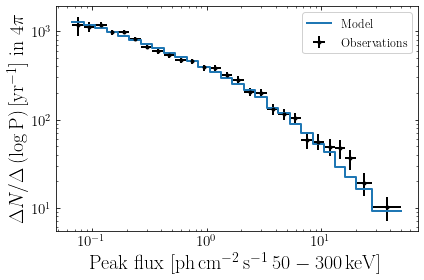

In [18]:
norm_Stern, mod_Stern = obs.compare_to_Stern(df[df['pdet_Stern']==1]['pht_pflx_BATSE'],
                         Stern_file=paths_to_dir['obs']/'Stern_lognlogp_rebinned.txt',
                         Nb_GRBs=Nb_GRBs, show_plot=True)

14:18:49.526 [INFO]           EpGBM chi2: 9.7515e+00
14:18:49.527 [INFO]  EpGBM normalization: 6.7659e-02


9.751525185658139

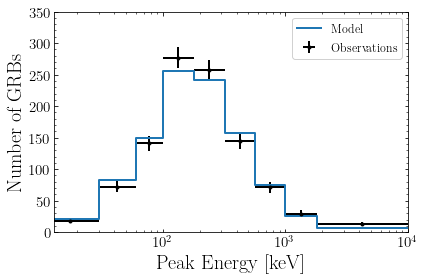

In [11]:
obs.compare_to_EpGBM(df[df['pdet_EpGBM']==1]['Epobs'],
                         GBM_file=paths_to_dir['obs']/'Ep_GBM_for_plotting.txt',
                        show_plot=True)


14:18:50.202 [INFO]           eBAT6 chi2: 1.1273e+01
14:18:50.202 [INFO]  eBAT6 normalization: 7.1373e-03


11.2729649395271

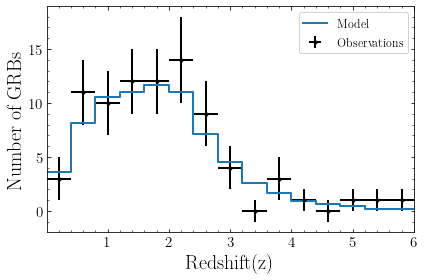

In [12]:
obs.compare_to_eBAT6(df[df['pdet_eBAT6']==1]['z'],
                     eBAT6_file=paths_to_dir['obs']/'eBAT6_constraint_for_plotting.txt',
                     show_plot=True)


In [13]:
f90_dir = paths_to_dir['output'].parent/'191205_best_k1_LN_nF'


In [14]:
dt = 'i4,i4,12f8,11f8,i4'
# i, L, z, D_L, Epobs, alpha, beta, ktild, Peakflux_Instrument, Prob_det
with open(f90_dir/'GRB_properties 0.dat', 'rb') as f:
    data = np.fromfile(f, dtype=dt, count=-1)
df_f90 = np.zeros((len(data),12))
for i,dat in enumerate(data):
    df_f90[i] = dat[2]

df_f90 = pd.DataFrame(df_f90, columns=['L', 'z', 'D_L', 'Epobs', 'alpha', 'beta', 'ktild',
                                     'pht_pflx_BATSE','pht_pflx_BAT','pht_pflx_FREGATE','pht_pflx_WXM','pht_pflx_ECLAIRs'])
# df_f90['L'] = np.log10(df_f90['L'])

14:18:55.265 [INFO] Global GRB rate: [117.26818886 111.3533665  118.68206271  96.9480837   97.63607467
  81.43856386  66.8322183   59.54411614  53.42225734  47.33002501
  45.68990108  38.89496199  38.42643421  31.63153219  28.3511912
  20.61902411  19.91612652  13.121209    11.48106657  10.30950311
   5.85768775   5.62336601   4.92045298   3.74891788   3.51460605
   2.81168424   2.57737954]
14:18:55.274 [INFO]           Stern chi2: 2.1912e+01
14:18:55.275 [INFO]  Stern normalization: 1.3084e-02 yr-1
14:18:55.276 [INFO]  Simulation duration: 7.6428e+01 yr
14:18:55.276 [INFO]            ndot_LGRB: 3.2711e+03 LGRB/yr


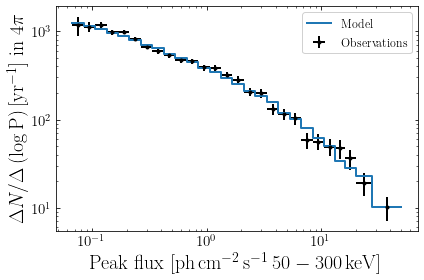

In [15]:
norm_Stern, mod_Stern = obs.compare_to_Stern(df_f90[df_f90['pht_pflx_BATSE']>=0.066825]['pht_pflx_BATSE'],
                         Stern_file=paths_to_dir['obs']/'Stern_lognlogp_rebinned.txt',
                         Nb_GRBs=Nb_GRBs, show_plot=True)

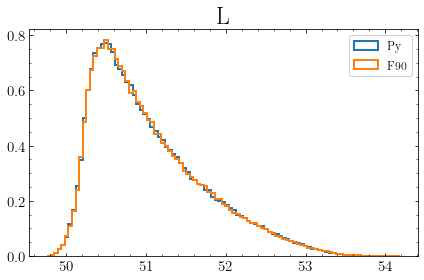

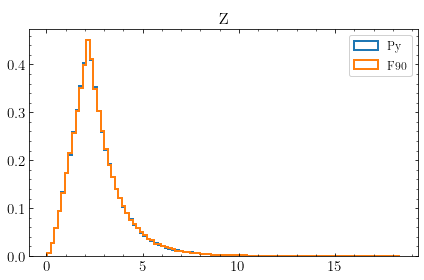

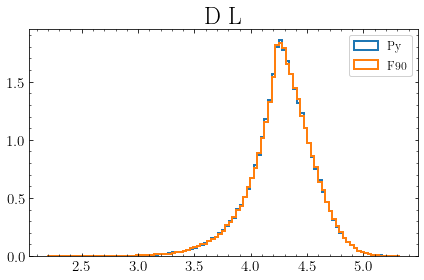

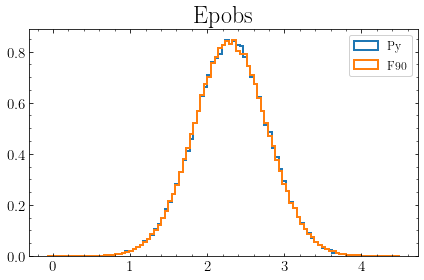

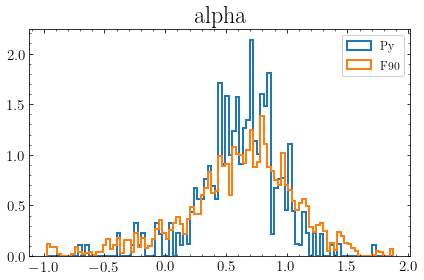

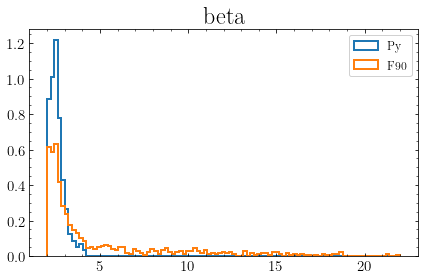

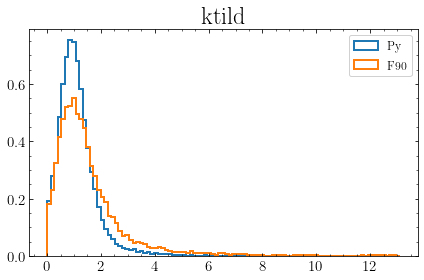

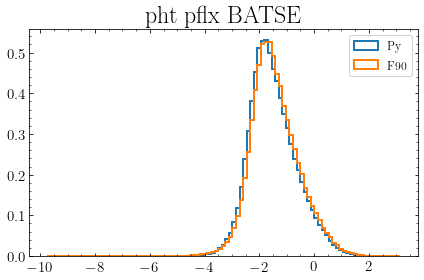

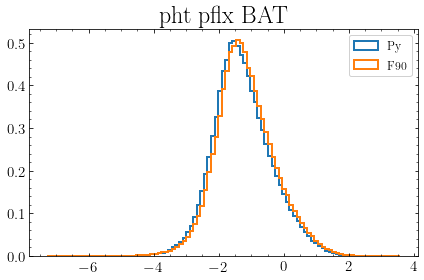

In [16]:
df_cols=['L', 'z', 'D_L', 'Epobs', 'alpha', 'beta', 'ktild', 'pht_pflx_BATSE','pht_pflx_BAT']
for col in df_cols:
    plt.figure()
    plt.title(col.replace('_',' '))
    if col in ['L', 'D_L', 'Epobs', 'pht_pflx_BATSE','pht_pflx_BAT']:
        binz = np.linspace(np.min([np.log10(df[col]),np.log10(df_f90[col])]),
                           np.max([np.log10(df[col]),np.log10(df_f90[col])]), 100)
        plt.hist(np.log10(df[col]), bins=binz, label='Py', density=True, histtype='step', linewidth=2)
        plt.hist(np.log10(df_f90[col]), bins=binz, label='F90', density=True, histtype='step', linewidth=2)
    else:
        binz = np.linspace(np.min([df[col],df_f90[col]]),
                           np.max([df[col],df_f90[col]]), 100)
        plt.hist(df[col], bins=binz, label='Py', density=True, histtype='step', linewidth=2)
        plt.hist(df_f90[col], bins=binz, label='F90', density=True, histtype='step', linewidth=2)
    plt.legend()
    plt.savefig(paths_to_dir['output']/(col.replace('_',' ')+'.pdf'))
#     plt.yscale('log')
plt.show()